# Training a Doc2Vec model
    -Doc2Vec is a library that vectorizes corpuses the same way that word2vec does. 

In [145]:
import time
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#language imports
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#word modeling
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore',message="Precision")

### So far we can scraped our text and cleaned it.
    -Now we need to load in the data and prepare it for Doc2Vec

In [146]:
#load data
lectures = pd.read_csv('all_lecture_text.csv')
lectures.head()

,Subject,title,d2v_text
0,Calculus,"Lec 39 | MIT 18.01 Single Variable Calculus, F...",PROFESSOR: So ||Comma|| ||Return|| Professor...
1,Probability,S01.0 Mathematical Background Overview,concepts ||Period|| I should say that ||Retur...
2,CS,8. Object Oriented Programming,FESSOR: All right everyone ||Period|| Let's g...
3,Algorithms,Recitation 9b: DNA Sequence Matching,OFESSOR: The things we ||Return|| can talk abo...
4,Algorithms,R10. Quiz 1 Review,FESSOR: All right ||Period|| So I brought a f...


In [147]:
#Split the df for training and testing
train, test = train_test_split(lectures.reset_index(drop=True), test_size=.30, random_state=43)

#The Doc2Vec model takes 'tagged_documents'
#tag the training data
tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(train.d2v_text)]

#tag testing data
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(test.d2v_text)]


In [148]:
len(tagged_tr),len(tagged_test)

(602, 258)

In [ ]:
#Instantiate the model

model = Doc2Vec(vector_size=100, # 100 should be fine based on the standards
                window=5, #change to 8
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=2, #ignores all words with total frequency lower than this.
                dm =1, #algorith 1=distributed memory
                workers=16)#cores to use

#build the vocab on the training data
model.build_vocab(tagged_tr)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
sns.set(style='dark', context='talk')
#Train the model
tsne = TSNE(2, random_state=43)
#max training epochs
max_epochs = 100
sil_scores = []
#train n epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch+1))
    model.train(tagged_tr,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    #print every 5 epochs
    if epoch%25 == 0:
        vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_tr))])
        tsne_df = tsne.fit_transform(vecs)
        plt.figure(figsize=(12,9))
        sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=train.Subject, legend='full')
        plt.legend(prop={'size': 8},bbox_to_anchor=[1,1])
        plt.show()

print("done!")
t2 = time.time()    
model.save("5klects.model")
#print("Model Saved")
print("Time: {}".format(t2-t1))

iteration 1


NameError: name 'model' is not defined

In [150]:
model = Doc2Vec.load("full_lects.model")

In [151]:
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_tr))])

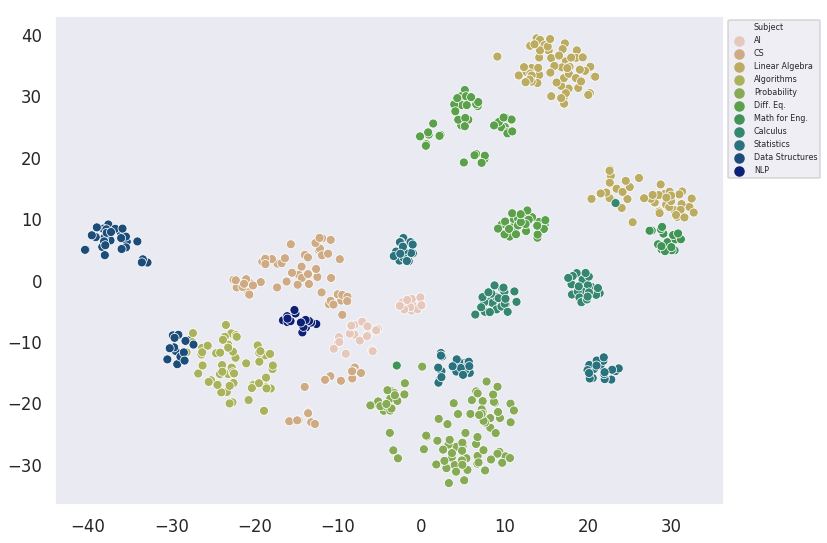

In [152]:
tsne = TSNE(2, random_state=43)
tsne_d = tsne.fit_transform(vecs)

sns.set_context('talk')
plt.figure(figsize=(12,9))
sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=y_train,palette='gist_earth_r', legend='full')
plt.legend(prop={'size': 8}, bbox_to_anchor=[1,1])
plt.show()

# K means clustering

In [153]:
fnclusts = []
fsscores = [] 
favgobs = []
fobsstd = []

for no in range(3,50,1):
    t1 = time.time()
    fd2v_clusters = cluster.KMeans(n_clusters=no, random_state=43).fit_predict(vecs)    
    fnclusts.append(no)
    fsscores.append(silhouette_score(vecs, fd2v_clusters, metric='cosine'))
    favgobs.append(pd.value_counts(fd2v_clusters).mean())
    fobsstd.append(pd.value_counts(fd2v_clusters).std())


print("done!")

done!


Highest Silhouette Score: 0.2998 with 25 clusters


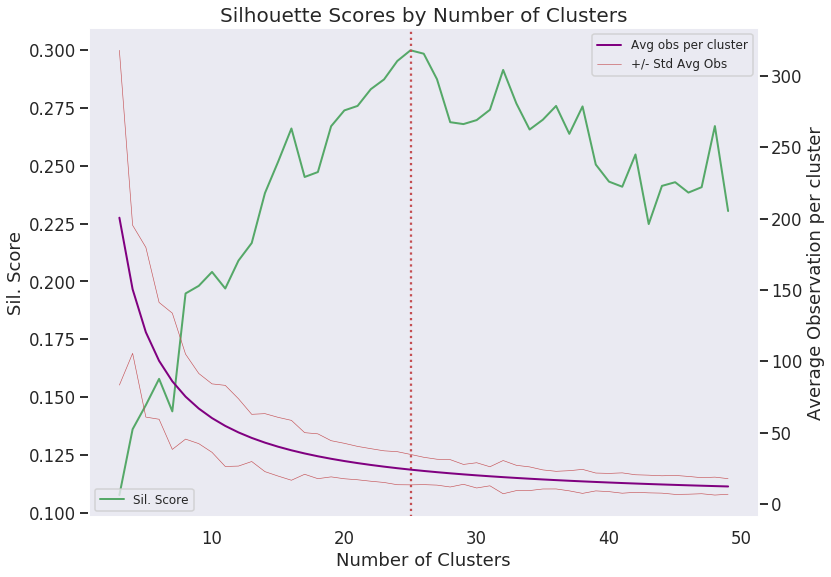

In [154]:
#Visualize Results
fobsstd1 = [ i+j for i,j in zip(favgobs,fobsstd)]
fstdneg = [ i-j for i,j in zip(favgobs,fobsstd)]

sns.set(context='talk', style='dark')
fig, ax = fig, ax = plt.subplots(figsize=(12,9))

ax2 = ax.twinx()
ax = sns.lineplot(fnclusts, fsscores,color='g', label='Sil. Score', linewidth=2, ax=ax)
ax2 =sns.lineplot(fnclusts, favgobs,color='purple',label='Avg obs per cluster', linewidth=2)
sns.lineplot(fnclusts,fobsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
sns.lineplot(fnclusts,fstdneg,color='r', linewidth=.6)

ax.set_ylabel('Sil. Score')
ax.set_xlabel('Number of Clusters')
ax.axvline(x=fnclusts[np.argmax(fsscores)],color='r',linestyle='dotted')


ax.legend(loc='lower left',prop={'size': 12})
ax2.legend(loc='upper right',prop={'size': 12})
plt.ylabel('Average Observation per cluster')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Scores by Number of Clusters',fontsize=20)
print("Highest Silhouette Score: {} with {} clusters".format(round(max(fsscores),4),fnclusts[np.argmax(fsscores)]))
#
plt.savefig("silscores.png")

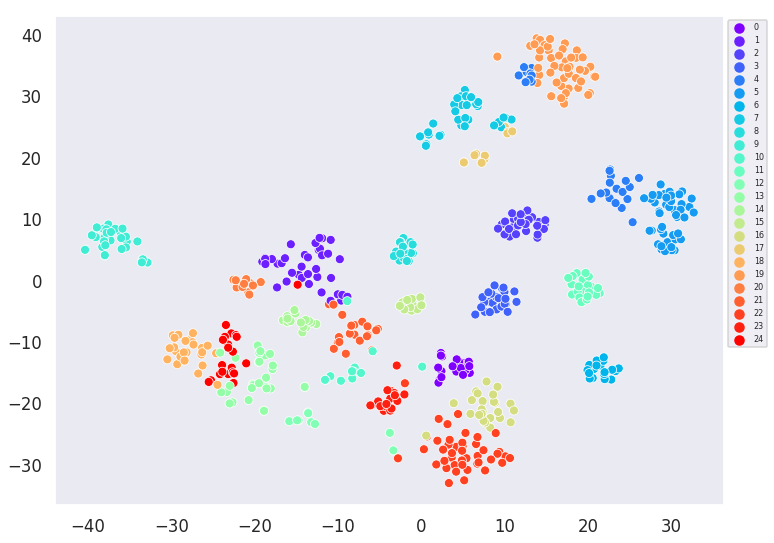

In [155]:
kclusters = cluster.KMeans(n_clusters=25, random_state=43).fit_predict(vecs)
sns.set_context('talk')
plt.figure(figsize=(12,9))
sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=kclusters,palette='rainbow', legend='full')
plt.legend(prop={'size': 8}, bbox_to_anchor=[1,1])
plt.show()

## Agglomerative Clustering

In [156]:
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, AgglomerativeClustering

'''n_clusters = range(3,50,1)
for cluster_n in n_clusters:
    agglo = AgglomerativeClustering(n_clusters=cluster_n, affinity='cosine',linkage='average')
    agglo.fit(vecs)
    labels = agglo.labels_
    print(silhouette_score(vecs, labels, metric='cosine'))'''
fnclusts = []
fsscores = [] 
favgobs = []
fobsstd = []

for no in range(3,50,1):
    t1 = time.time()
    agglo = AgglomerativeClustering(n_clusters=no, affinity='cosine',linkage='average').fit_predict(vecs)    
    fnclusts.append(no)
    fsscores.append(silhouette_score(vecs, agglo, metric='cosine'))
    favgobs.append(pd.value_counts(agglo).mean())
    fobsstd.append(pd.value_counts(agglo).std())


print("done!")

done!


Highest Silhouette Score: 0.2996 with 36 clusters


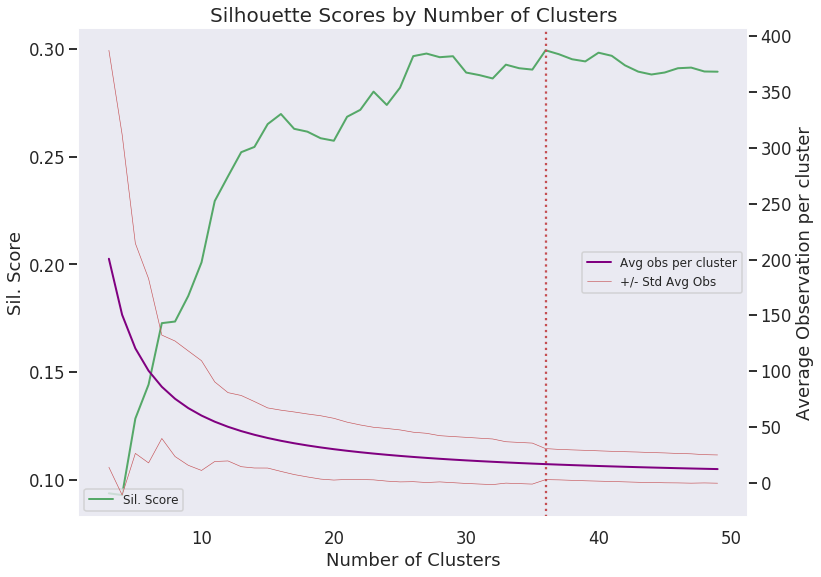

In [157]:
#Visualize Results
fobsstd1 = [ i+j for i,j in zip(favgobs,fobsstd)]
fstdneg = [ i-j for i,j in zip(favgobs,fobsstd)]

sns.set(context='talk', style='dark')
fig, ax = fig, ax = plt.subplots(figsize=(12,9))

ax2 = ax.twinx()
ax = sns.lineplot(fnclusts, fsscores,color='g', label='Sil. Score', linewidth=2, ax=ax)
ax2 =sns.lineplot(fnclusts, favgobs,color='purple',label='Avg obs per cluster', linewidth=2)
sns.lineplot(fnclusts,fobsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
sns.lineplot(fnclusts,fstdneg,color='r', linewidth=.6)

ax.set_ylabel('Sil. Score')
ax.set_xlabel('Number of Clusters')
ax.axvline(x=fnclusts[np.argmax(fsscores)],color='r',linestyle='dotted')


ax.legend(loc='lower left',prop={'size': 12})
ax2.legend(loc='center right',prop={'size': 12})
plt.ylabel('Average Observation per cluster')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Scores by Number of Clusters',fontsize=20)
print("Highest Silhouette Score: {} with {} clusters".format(round(max(fsscores),4),fnclusts[np.argmax(fsscores)]))

In [158]:
agglo = AgglomerativeClustering(n_clusters=36, affinity='cosine',linkage='average').fit_predict(vecs)

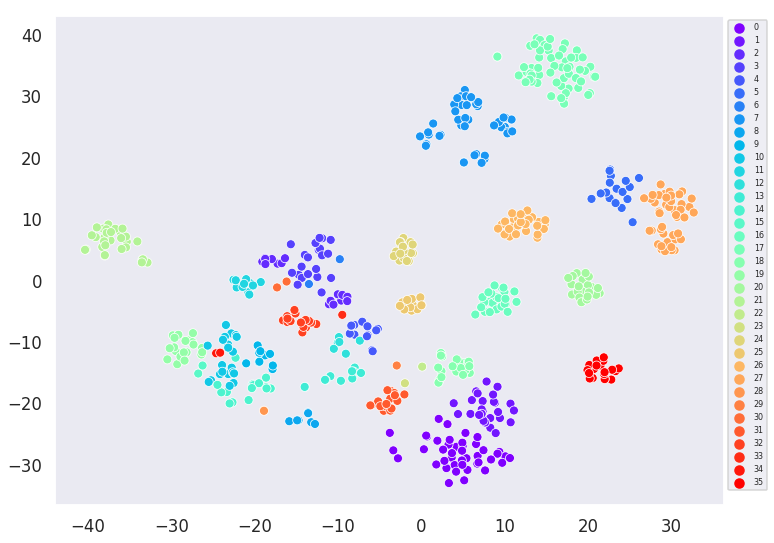

In [159]:
sns.set_context('talk')
plt.figure(figsize=(12,9))
sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=agglo,palette='rainbow', legend='full')
plt.legend(prop={'size': 8}, bbox_to_anchor=[1,1])
plt.show()

## Cosine Similarity
    -To calculate the cosine similarity, we take our vectors that represent lectures and calculate the pairwise cosine similarity between them

In [160]:
train.head()

,Subject,title,d2v_text
369,AI,2. Reasoning: Goal Trees and Problem Solving,gram ||Comma|| in any ||Return|| sense of the...
399,CS,Functions as Arguments,BELL: So here's some code ||Period|| I am ...
150,Linear Algebra,"Lec 8 | MIT 18.06 Linear Algebra, Spring 2005",ntify that ||Return|| possibility by eliminati...
850,Algorithms,R9. Approximation Algorithms: Traveling Salesm...,RTYA SHANKHA ||Return|| BISWAS: So today ||Com...
572,Algorithms,R8. Simulation Algorithms,FESSOR: We're going to ||Return|| cover hashin...


In [161]:
from sklearn.metrics.pairwise import cosine_similarity
d2v_fullsim = pd.DataFrame(cosine_similarity(vecs), index=train.title, columns=train.title)

In [162]:
d2v_fullsim.head()

title,2. Reasoning: Goal Trees and Problem Solving,Functions as Arguments,"Lec 8 | MIT 18.06 Linear Algebra, Spring 2005",R9. Approximation Algorithms: Traveling Salesman Problem,R8. Simulation Algorithms,"3. Law of Large Numbers, Convergence",Creating a slope field | First order differential equations | Khan Academy,Exact equations intuition 2 (proofy) | First order differential equations | Khan Academy,Lec 20 | MIT 18.086 Mathematical Methods for Engineers II,"Mega-R2. Basic Search, Optimal Search",...,Compositions of linear transformations 2 | Matrix transformations | Linear Algebra | Khan Academy,"Lec 10 | MIT 6.00 Introduction to Computer Science and Programming, Fall 2008","14. Learning: Sparse Spaces, Phonology",R1. Matrix Multiplication and the Master Theorem,21. Ideal Quantum Gases Part 1,Lecture 21: Covariance and Correlation | Statistics 110,"R9. Rolling Hashes, Amortized Analysis",Lec 4 | MIT 18.086 Mathematical Methods for Engineers II,"Lec 24 | MIT 18.03 Differential Equations, Spring 2006",Lecture 15: Midterm Review | Statistics 110
title,,,,,,,,,,,,,,,,,,,,,
2. Reasoning: Goal Trees and Problem Solving,1.000000,0.280849,0.037819,0.274961,0.093424,0.258638,0.157346,0.294806,0.129315,0.409647,...,0.260444,0.127272,0.435327,0.123066,0.095748,0.046964,0.090769,0.134158,0.390706,0.100986
Functions as Arguments,0.280849,1.000000,0.069861,0.288418,0.266519,0.202549,0.183317,0.259443,0.121181,0.206529,...,0.175173,0.182559,-0.040098,0.143188,0.047752,0.033814,0.234969,0.119353,0.045464,0.104268
"Lec 8 | MIT 18.06 Linear Algebra, Spring 2005",0.037819,0.069861,1.000000,-0.000742,0.122166,0.002927,0.108897,0.258011,0.547228,0.058990,...,0.338583,0.092000,0.158844,0.189158,0.120776,0.088211,0.065074,0.471353,0.298705,0.069185
R9. Approximation Algorithms: Traveling Salesman Problem,0.274961,0.288418,-0.000742,1.000000,0.138615,0.143014,0.086655,0.135702,0.140023,0.399997,...,0.086843,-0.022142,0.075792,0.312393,0.142267,0.100883,0.191181,0.134184,0.047762,0.111998
R8. Simulation Algorithms,0.093424,0.266519,0.122166,0.138615,1.000000,0.162511,-0.013466,0.046938,0.145578,0.274767,...,-0.003942,0.265988,0.029106,0.306714,0.144129,0.031431,0.658312,0.097571,0.126016,0.091416


In [190]:
heat_df = pd.DataFrame(cosine_similarity(vecs))
heat_df['subjects'] = train.Subject.reset_index(drop=True)
#Calculate mean similarity of each lecture
heat_df.insert(0, 'mean_similarity', heat_df.mean(axis=1))

In [164]:
heat_df['subjects'] = train.Subject.reset_index(drop=True)

In [191]:
#Calculate mean similarity of each lecture
heat_df.insert(0, 'mean_similarity', heat_df.mean(axis=1))

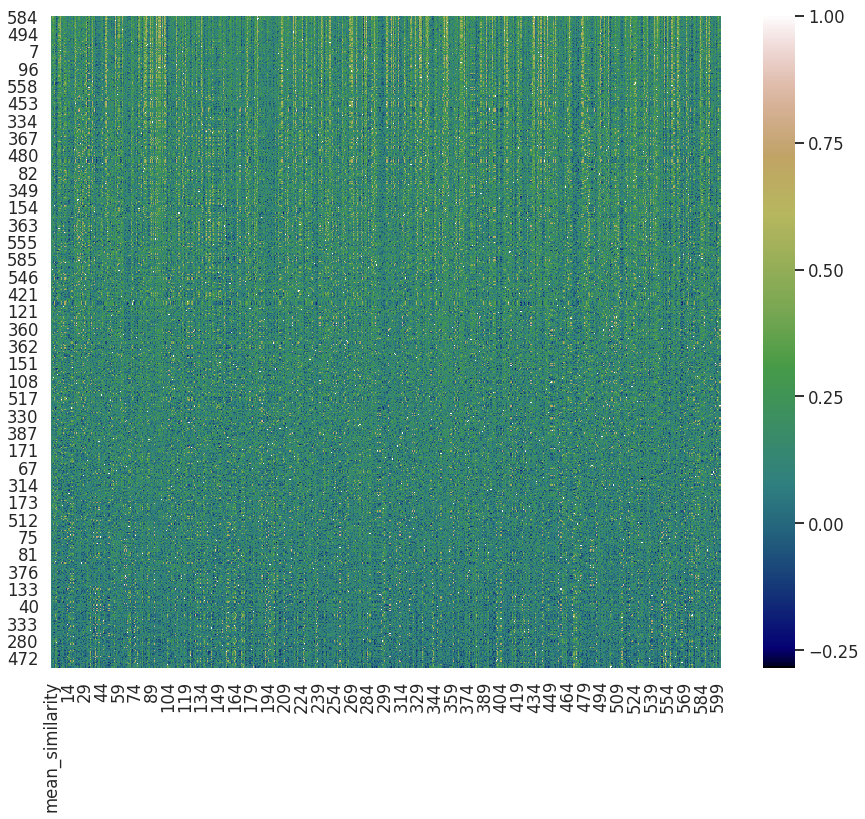

In [194]:
plt.figure(figsize=(15,12))
sns.heatmap(heat_df.sort_values(by='mean_similarity',ascending=False),cmap='gist_earth')
plt.show()

In [167]:
#calculate the mean similarity between lectures
d2v_fullsim.insert(0, 'mean_similarity', d2v_fullsim.mean(axis=1))

In [ ]:
d2v_fullsim.to_csv('doc2vec_cosimilarity.csv')

In [168]:
heat_csv = pd.read_csv('doc2vec_cosimilarity.csv')

In [169]:
#add identification to similarity dataframe
d2v_fullsim['Subject'] = list(train.Subject)

In [196]:
#test the response on a lecture
lecture = train.title[62]
d2v_fullsim[[lecture,'Subject','mean_similarity']].sort_values(by=[lecture],ascending=False)[:15]

title,17. Succinct Structures I,Subject,mean_similarity
title,,,
17. Succinct Structures I,1.000000,Data Structures,0.101751
15. Static Trees,0.751220,Data Structures,0.116894
16. Strings,0.715761,Data Structures,0.109921
11. Integer Models,0.706285,Data Structures,0.111308
12. Fusion Trees,0.688259,Data Structures,0.101052
8. Cache-Oblivious Structures I,0.658115,Data Structures,0.100018
7. Memory Hierarchy Models,0.649207,Data Structures,0.115459
4. Divide & Conquer: van Emde Boas Trees,0.599482,Algorithms,0.109208
22. History of Memory Models,0.588536,Data Structures,0.111912


In [171]:
#what is the highest mean similarity?
d2v_fullsim.sort_values(by='mean_similarity',ascending=False)[['mean_similarity','Subject']][:10]

title,mean_similarity,Subject
title,,
2nd order linear homogeneous differential equations 1 | Khan Academy,0.219275,Diff. Eq.
Using the Laplace transform to solve a nonhomogeneous eq | Laplace transform | Khan Academy,0.218520,Diff. Eq.
Undetermined coefficients 2 | Second order differential equations | Khan Academy,0.217208,Diff. Eq.
Laplace/step function differential equation | Laplace transform | Khan Academy,0.216045,Diff. Eq.
Repeated roots of the characteristic equation | Second order differential equations | Khan Academy,0.214515,Diff. Eq.
2nd order linear homogeneous differential equations 3 | Khan Academy,0.208300,Diff. Eq.
Linear transformations | Matrix transformations | Linear Algebra | Khan Academy,0.206084,Linear Algebra
First order homogenous equations | First order differential equations | Khan Academy,0.205912,Diff. Eq.
Proof of the Cauchy-Schwarz inequality | Vectors and spaces | Linear Algebra | Khan Academy,0.205826,Linear Algebra


In [185]:
d2v_fullsim.groupby('Subject')['mean_similarity'].mean().mean()

0.14450145113135823

In [197]:
d2v_fullsim.mean_similarity.mean()

0.15157275018628782

In [204]:
model.infer_vector(tagged_test[1][0])

array([ 0.8967604 ,  1.0209696 , -0.36862352,  1.3319519 , -1.3866873 ,
        0.7810455 , -0.91545445, -0.48233134, -0.83139783,  1.897358  ,
        1.012804  ,  0.89463747,  0.95139104, -0.10814607, -0.27682954,
        2.0274582 , -0.53534555, -1.1078746 ,  0.02437129,  1.5470012 ,
       -0.15323485, -0.6633934 , -1.345649  , -0.4224376 , -0.8614822 ,
        1.6571192 ,  0.90442944, -2.0305498 , -0.85201484, -0.73215467,
       -0.96367824,  2.147244  ,  0.0761278 ,  1.0991696 ,  0.38062444,
        0.390921  , -1.6627183 , -1.020548  ,  0.5344223 ,  1.2543728 ,
        1.1986542 , -0.9670452 , -0.33716732,  1.4381071 , -0.82367855,
        0.04844704, -0.5386229 , -1.5114484 , -0.32223773,  0.2791088 ,
        1.1855214 ,  1.6184843 ,  0.45925325,  0.27133214, -2.1207747 ,
        0.21982315,  2.0141222 ,  0.60845965,  0.11763635, -1.518003  ,
        0.06648722, -1.8170862 ,  2.1002543 , -0.04053281, -0.33014897,
        0.47594815, -0.47706363, -0.16597582,  0.0576668 ,  0.55

## Create modeling data

In [200]:
#Now that we have the embedding trained, we can use the infer vector method to convert the test sentences into vectors
#that can be used to model 

# Extract vectors from doc2vec model
X_train = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_tr))])
y_train = train.Subject

# Extract test values
X_test = pd.DataFrame([model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test.Subject

In [201]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((602, 100), (602,), (258, 100), (258,))

In [205]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.019335,0.284618,-0.124614,0.918102,-1.127095,0.433721,-0.947816,-0.991775,-0.026887,-0.139668,...,-0.272859,0.147172,-0.217416,0.323969,1.150092,0.415943,-0.165722,0.067758,0.116096,0.040389
1,0.846180,1.224350,-0.372820,1.700355,-1.298949,0.777764,-0.836882,-0.580685,-0.987938,1.854581,...,-1.744086,0.090503,-0.010231,-0.847847,-0.009636,-0.248245,-0.132507,0.017214,-0.587237,0.364343
2,-0.448693,-2.297260,-0.201844,0.559638,0.991429,1.029112,0.927266,-0.919522,1.098181,-1.708329,...,0.399253,-0.191294,1.311070,0.531367,0.814285,0.579976,-0.660575,-0.965857,0.351361,2.602881
3,0.076742,-0.232096,-0.067455,0.915695,-0.722524,1.063343,-0.784368,-0.823707,0.213903,-0.260353,...,-0.469156,0.132333,-0.289859,0.089587,0.235260,0.238876,0.486319,0.003627,0.390471,0.527240
4,1.194202,-1.652345,0.903948,1.857545,1.097706,0.957156,1.424109,-1.407985,2.003461,-1.739742,...,-0.387051,-0.855210,1.086884,-0.849126,0.448604,0.798971,-0.932434,0.932475,-0.234830,1.661881


# Logistic Regression

In [208]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [206]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

In [210]:
cs = []
Classes = []
Penalties = []
Solvers = []
f1s = []
recalls = []
precs = []

Cs = [1,2,5,8,13,15,17,20,25,30]
multi_classes=['ovr','multinomial']
penalties = ['l2']
solvers = ['lbfgs','newton-cg','saga']


for multi_class in multi_classes:
    for penalty in penalties:
        for solver in solvers:

            for C in Cs:

                lrc = LogisticRegression(C=C, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, max_iter=1000, multi_class=multi_class, n_jobs=8,
                      penalty=penalty, random_state=43, solver=solver, tol=0.0001,
                      verbose=0, warm_start=False)
                lrc.fit(X_train,y_train)
                y_pred = lrc.predict(X_test)
                f1avg = classification_report(y_test,y_pred)[786:790]
                recallavg = classification_report(y_test,y_pred)[776:779]
                precavg = classification_report(y_test,y_pred)[766:770]
                cs.append(C)
                Classes.append(multi_class)
                Penalties.append(penalty)
                Solvers.append(solver)
                f1s.append(f1avg)
                recalls.append(recallavg)
                precs.append(precavg)
                
                    
                    

/home/extralime/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/extralime/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/extralime/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/extralime/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/extralime/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was

In [211]:
#create a data from with the results
lrc_df = pd.DataFrame()
lrc_df['f1']= [float(re.sub('\s*','',i)) for i in f1s]
lrc_df['recall'] = [float(re.sub('\s*','',i)) for i in recalls]
lrc_df['precision'] = [float(re.sub('\s*','',i)) for i in precs]
lrc_df['solver'] = Solvers
lrc_df['penalty'] = Penalties
lrc_df['class'] = Classes
lrc_df['C'] = cs
lrc_df.head()

,f1,recall,precision,solver,penalty,class,C
0,0.71,0.71,0.87,lbfgs,l2,ovr,1
1,0.71,0.72,0.87,lbfgs,l2,ovr,2
2,0.71,0.72,0.87,lbfgs,l2,ovr,5
3,0.70,0.72,0.87,lbfgs,l2,ovr,8
4,0.70,0.72,0.87,lbfgs,l2,ovr,13


In [217]:
lrc_df.sort_values(by='f1',ascending=False)[:20]

,f1,recall,precision,solver,penalty,class,C
59,0.95,0.95,0.95,saga,l2,multinomial,30
58,0.95,0.95,0.95,saga,l2,multinomial,25
57,0.95,0.95,0.95,saga,l2,multinomial,20
56,0.95,0.95,0.95,saga,l2,multinomial,17
55,0.95,0.95,0.95,saga,l2,multinomial,15
54,0.95,0.95,0.95,saga,l2,multinomial,13
53,0.95,0.95,0.95,saga,l2,multinomial,8
52,0.95,0.95,0.95,saga,l2,multinomial,5
51,0.95,0.95,0.95,saga,l2,multinomial,2
50,0.94,0.94,0.95,saga,l2,multinomial,1


In [233]:
lrc = LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, max_iter=1000, multi_class='multinomial', n_jobs=8,
                      penalty='l2', random_state=43, solver='saga', tol=0.0001,
                      verbose=0, warm_start=False)
lrc.fit(X_train,y_train)

/home/extralime/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=8, penalty='l2', random_state=43, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [248]:
X = np.concatenate([X_train,X_test],axis=0)

In [255]:
y = pd.concat([y_train,y_test], axis=0)

In [269]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [271]:
cv_stds = []
cv_means = []
for i in range(2,17,1):
    cvscors = cross_val_score(lrc,X,y,cv=i)
    cv_means.append(cvscors.mean())
    cv_stds.append(cvscors.std())
    cv_mean,cv_std

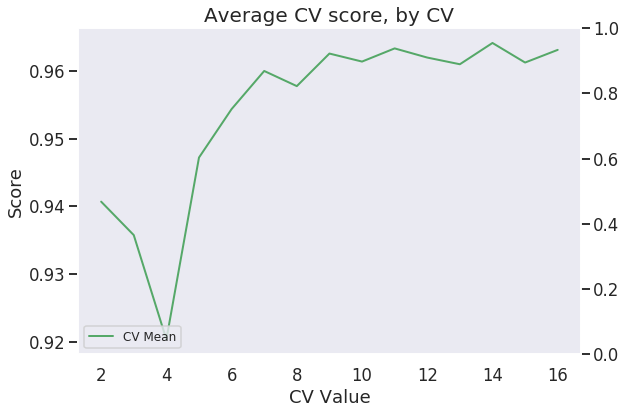

In [279]:
#Visualize Results
fobsstd1 = [ i+j for i,j in zip(cv_means,cv_stds)]
fstdneg = [ i-j for i,j in zip(cv_means,cv_stds)]

sns.set(context='talk', style='dark')
fig, ax = fig, ax = plt.subplots(figsize=(9,6))

ax2 = ax.twinx()
ax = sns.lineplot(range(2,17,1), cv_means,color='g', label='CV Mean', linewidth=2, ax=ax)
#ax2 =sns.lineplot(range(2,15,1), favgobs,color='purple',label='Avg obs per cluster', linewidth=2)
#sns.lineplot(range(2,17,1),fobsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
#sns.lineplot(range(2,17,1),fstdneg,color='r', linewidth=.6)

ax.set_ylabel('Score')
ax.set_xlabel('CV Value')
#ax.axvline(x=range(2,17,1)[np.argmax(cv_means)],color='r',linestyle='dotted')


ax.legend(loc='lower left',prop={'size': 12})
#ax2.legend(loc='center right',prop={'size': 12})
#plt.ylabel('Score')
#plt.xlabel('CV value')
plt.title('Average CV score, by CV',fontsize=20)
plt.show()

In [259]:
cvscors

array([0.94505495, 0.97777778, 0.98863636, 0.97701149, 0.96470588,
       0.98823529, 0.94117647, 0.96470588, 0.91566265, 0.95061728])

In [ ]:
y_pred = lrc.predict(X_test)
heatconmat(y_test,y_pred)

In [220]:
cs = []
kernels = []
shapes = []

f1s = []
recalls = []
precs = []


Cs = [.5,1,3,5,8,13,15,20,25,30]
df_shape=['ovr','multinomial']
kernel = ['linear','poly']


for kern in kernel:
    for shape in df_shape:

            i = 1
            for C in Cs:

                svc = SVC(C=C, decision_function_shape=shape, max_iter=-1, kernel=kern,random_state=43, 
                          tol=0.0001, gamma='auto')
                svc.fit(X_train,y_train)
                y_pred = svc.predict(X_test)
                f1avg = classification_report(y_test,y_pred)[786:790]
                recallavg = classification_report(y_test,y_pred)[776:779]
                precavg = classification_report(y_test,y_pred)[766:770]
                cs.append(C)
                kernels.append(kern)
                shapes.append(shape)

                f1s.append(f1avg)
                recalls.append(recallavg)
                precs.append(precavg)
                

In [221]:
svc_df = pd.DataFrame()
svc_df['f1']= [float(re.sub('\s*','',i)) for i in f1s]
svc_df['recall'] = [float(re.sub('\s*','',i)) for i in recalls]
svc_df['precision'] = [float(re.sub('\s*','',i)) for i in precs]

svc_df['kernel'] = kernels
svc_df['df_shape'] = shapes
svc_df['C'] = cs

svc_df.head()

,f1,recall,precision,kernel,df_shape,C
0,0.71,0.71,0.88,linear,ovr,0.5
1,0.71,0.71,0.88,linear,ovr,1.0
2,0.71,0.71,0.88,linear,ovr,3.0
3,0.71,0.71,0.88,linear,ovr,5.0
4,0.71,0.71,0.88,linear,ovr,8.0


In [223]:
svc_df.sort_values(by='f1',ascending=False)[:10]

,f1,recall,precision,kernel,df_shape,C
0,0.71,0.71,0.88,linear,ovr,0.5
11,0.71,0.71,0.88,linear,multinomial,1.0
1,0.71,0.71,0.88,linear,ovr,1.0
19,0.71,0.71,0.88,linear,multinomial,30.0
18,0.71,0.71,0.88,linear,multinomial,25.0
17,0.71,0.71,0.88,linear,multinomial,20.0
16,0.71,0.71,0.88,linear,multinomial,15.0
15,0.71,0.71,0.88,linear,multinomial,13.0
13,0.71,0.71,0.88,linear,multinomial,5.0
12,0.71,0.71,0.88,linear,multinomial,3.0


# Random Forest


In [226]:
-

In [230]:
#create a data from with the results
rfc_df = pd.DataFrame()
rfc_df['f1']= [float(re.sub('\s*','',i)) for i in f1s]
rfc_df['recall'] = [float(re.sub('\s*','',i)) for i in recalls]
rfc_df['precision'] = [float(re.sub('\s*','',i)) for i in precs]
rfc_df['n_ests'] = estims
rfc_df['max_depths'] = mds
rfc_df['min_leaf'] = msls
rfc_df['min_split'] = msss
rfc_df['ctriteron'] = crit
rfc_df.head()

,f1,recall,precision,n_ests,max_depths,min_leaf,min_split,ctriteron
0,0.22,0.26,0.31,100,2,2,2,gini
1,0.22,0.26,0.31,100,2,2,3,gini
2,0.22,0.26,0.31,100,2,2,4,gini
3,0.22,0.26,0.31,100,2,2,5,gini
4,0.22,0.26,0.31,100,2,3,2,gini


In [234]:
rfc_df.sort_values(by='f1',ascending=False)[:10]

,f1,recall,precision,n_ests,max_depths,min_leaf,min_split,ctriteron
513,0.7,0.69,0.88,100,6,2,3,entropy
658,0.7,0.70,0.88,300,12,2,4,entropy
733,0.7,0.70,0.89,500,7,5,3,entropy
734,0.7,0.70,0.89,500,7,5,4,entropy
514,0.7,0.69,0.88,100,6,2,4,entropy
512,0.7,0.69,0.88,100,6,2,2,entropy
735,0.7,0.70,0.89,500,7,5,5,entropy
657,0.7,0.70,0.88,300,12,2,3,entropy
656,0.7,0.70,0.88,300,12,2,2,entropy
820,0.7,0.70,0.79,700,7,3,2,entropy


In [235]:
from sklearn import naive_bayes, neighbors

In [237]:
   knn = neighbors.KNeighborsClassifier(n_neighbors=5,weights='distance')

In [241]:
neighs= []
f1s = []
recalls = []
precs = []


ns = [2,3,5,7,10]

for n in ns:
    knn = neighbors.KNeighborsClassifier(n_neighbors=n,weights='distance')
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    f1avg = classification_report(y_test,y_pred)[786:790]
    recallavg = classification_report(y_test,y_pred)[776:779]
    precavg = classification_report(y_test,y_pred)[766:770]
    neighs.append(n)

    f1s.append(f1avg)
    recalls.append(recallavg)
    precs.append(precavg)

In [245]:
-

ValueError: ExponentialLoss requires 2 classes; got 11 class(es)

In [246]:
gbc_df = pd.DataFrame()
gbc_df['f1']= [float(re.sub('\s*','',i)) for i in f1s]
gbc_df['recall'] = [float(re.sub('\s*','',i)) for i in recalls]
gbc_df['precision'] = [float(re.sub('\s*','',i)) for i in precs]
gbc_df['n_ests'] = estims
gbc_df['max_depths'] = mds
gbc_df['min_leaf'] = msls
gbc_df['min_split'] = msss
gbc_df['loss'] = lossess
gbc_df.head()

,f1,recall,precision,n_ests,max_depths,min_leaf,min_split,loss
0,0.32,0.34,0.60,100,2,2,2,deviance
1,0.32,0.34,0.60,100,2,2,3,deviance
2,0.32,0.34,0.60,100,2,2,4,deviance
3,0.30,0.32,0.60,100,2,2,5,deviance
4,0.37,0.39,0.69,100,2,3,2,deviance


In [247]:
gbc_df.sort_values(by='f1',ascending=False)

,f1,recall,precision,n_ests,max_depths,min_leaf,min_split,loss
397,0.51,0.54,0.70,900,2,5,3,deviance
109,0.51,0.54,0.70,300,2,5,3,deviance
206,0.51,0.54,0.70,500,2,5,4,deviance
302,0.51,0.54,0.70,700,2,5,4,deviance
301,0.51,0.54,0.70,700,2,5,3,deviance
300,0.51,0.54,0.70,700,2,5,2,deviance
205,0.51,0.54,0.70,500,2,5,3,deviance
204,0.51,0.54,0.70,500,2,5,2,deviance
108,0.51,0.54,0.70,300,2,5,2,deviance
110,0.51,0.54,0.70,300,2,5,4,deviance
